In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.layers import Input, UpSampling2D,BatchNormalization, ZeroPadding2D, Reshape, Permute
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import cv2

In [78]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [40]:
from keras.applications import MobileNetV2

def mobilenetv2_unet():
    inputs = Input((224, 224, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 64, 128]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [41]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [42]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(224, 224))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(224, 224), grayscale=True)

In [43]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [44]:
from keras.optimizers import Adam

model = mobilenetv2_unet()
metrics = ["acc", iou, dice_coef, tversky]
model.compile(loss=dice_coef_loss, optimizer=Adam(learning_rate=0.001), metrics=metrics)

history = model.fit(images_train, masks_train,
                    batch_size = 8,
                    epochs=45,
                    validation_data = (images_test, masks_test))

Epoch 1/45
83/83 [==============================] - 33s 83ms/step - loss: 0.4863 - acc: 0.9205 - iou: 0.3520 - dice_coef: 0.5142 - tversky: 0.6300 - val_loss: 0.6116 - val_acc: 0.9449 - val_iou: 0.2440 - val_dice_coef: 0.3894 - val_tversky: 0.5121
Epoch 2/45
83/83 [==============================] - 6s 68ms/step - loss: 0.3210 - acc: 0.9626 - iou: 0.5216 - dice_coef: 0.6798 - tversky: 0.7727 - val_loss: 0.4810 - val_acc: 0.8795 - val_iou: 0.3561 - val_dice_coef: 0.5201 - val_tversky: 0.6361
Epoch 3/45
83/83 [==============================] - 6s 68ms/step - loss: 0.1852 - acc: 0.9654 - iou: 0.6923 - dice_coef: 0.8152 - tversky: 0.8736 - val_loss: 0.3815 - val_acc: 0.8725 - val_iou: 0.4555 - val_dice_coef: 0.6195 - val_tversky: 0.7245
Epoch 4/45
83/83 [==============================] - 6s 70ms/step - loss: 0.1095 - acc: 0.9658 - iou: 0.8045 - dice_coef: 0.8907 - tversky: 0.9240 - val_loss: 0.6837 - val_acc: 0.4665 - val_iou: 0.1912 - val_dice_coef: 0.3174 - val_tversky: 0.4320
Epoch 5/45


In [73]:
results = model.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.35, 1, 0), axis=-1)

6/6 [==============================] - 0s 78ms/step


In [74]:
results[0].shape

(224, 224, 1)

In [75]:
model.evaluate(images_test, masks_test)

6/6 [==============================] - 0s 72ms/step - loss: 0.0200 - acc: 0.9721 - iou: 0.9626 - dice_coef: 0.9809 - tversky: 0.9847


[0.02004832588136196,
 0.9721062779426575,
 0.9625886082649231,
 0.980920135974884,
 0.984685480594635]

In [80]:
model.save('mobilenetv2_unet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


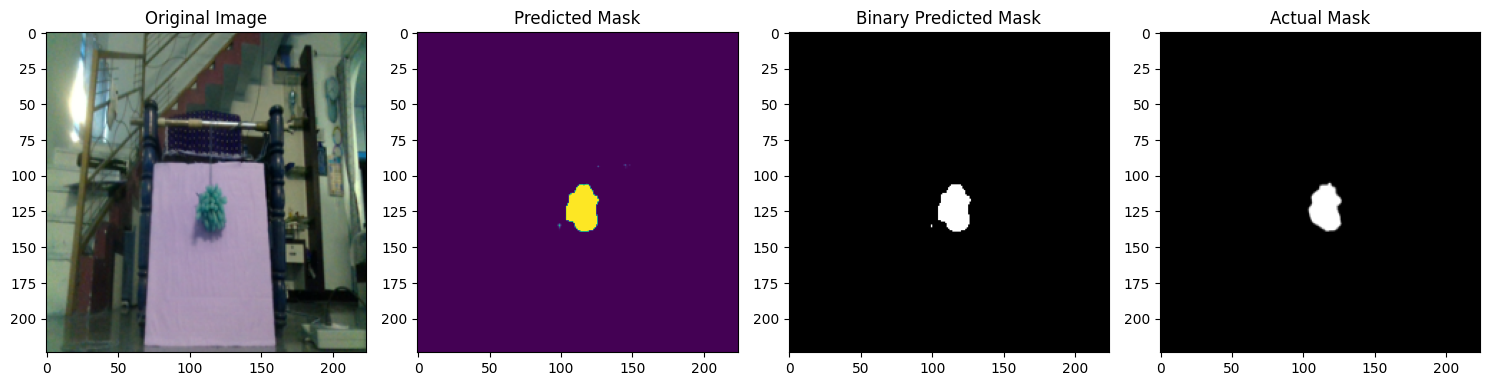

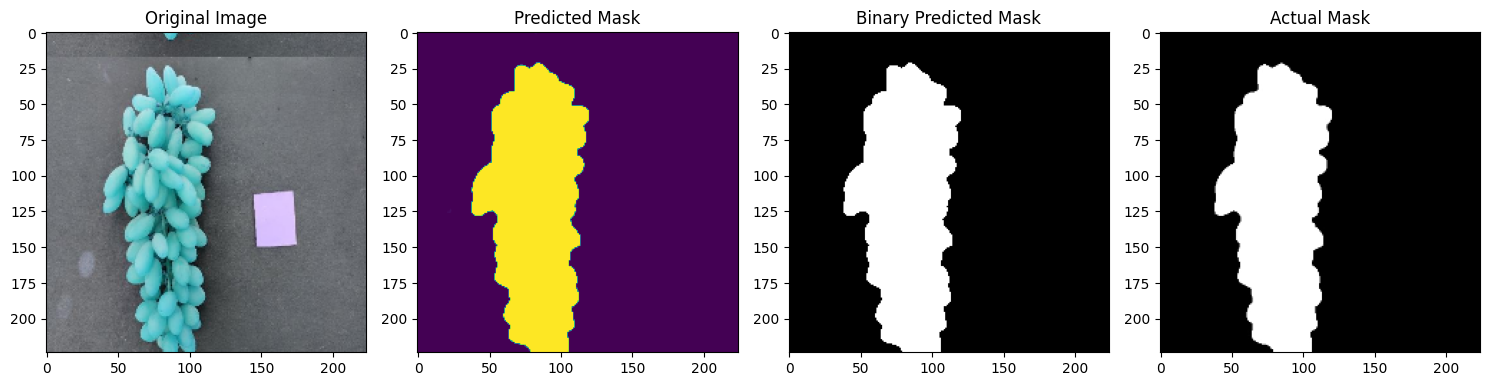

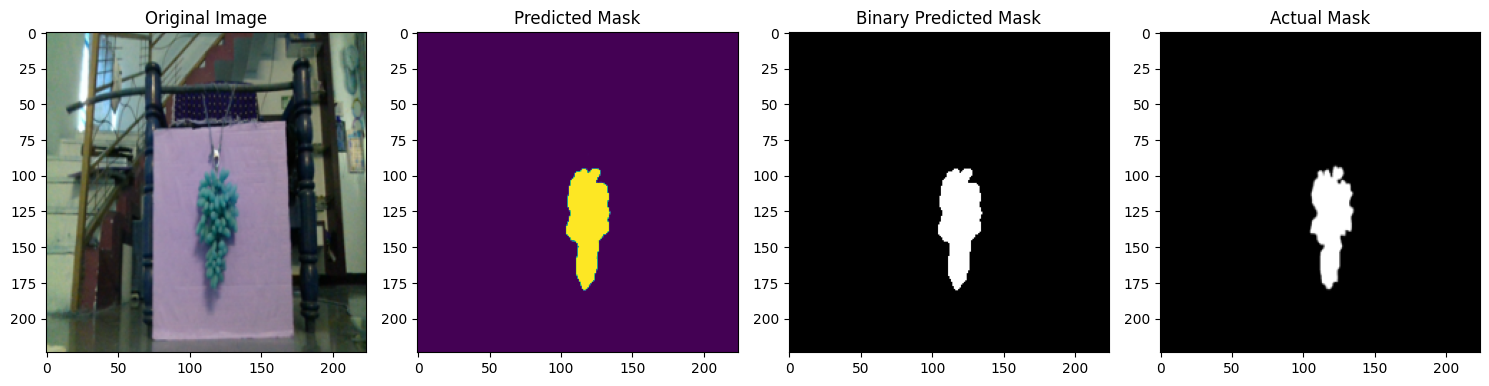

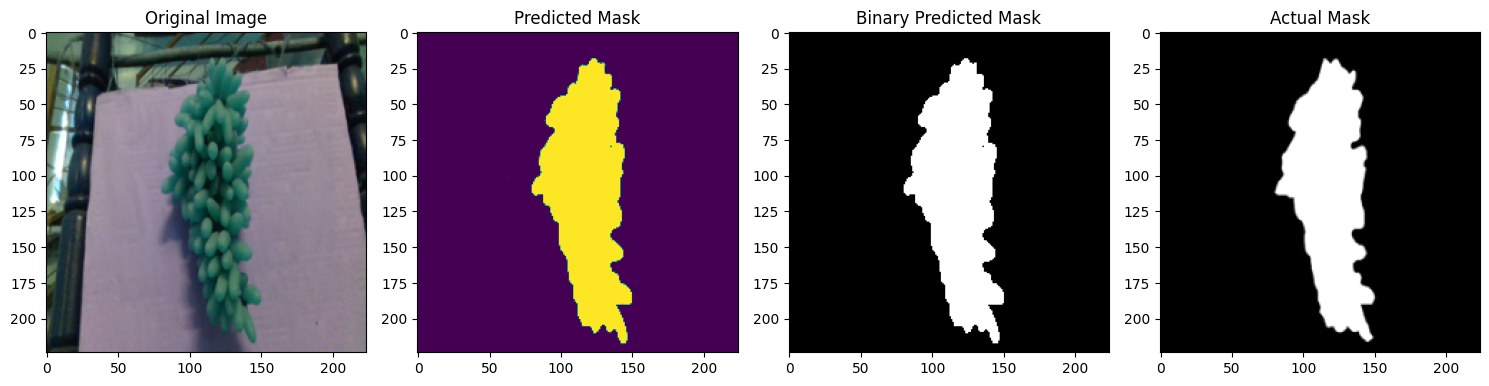

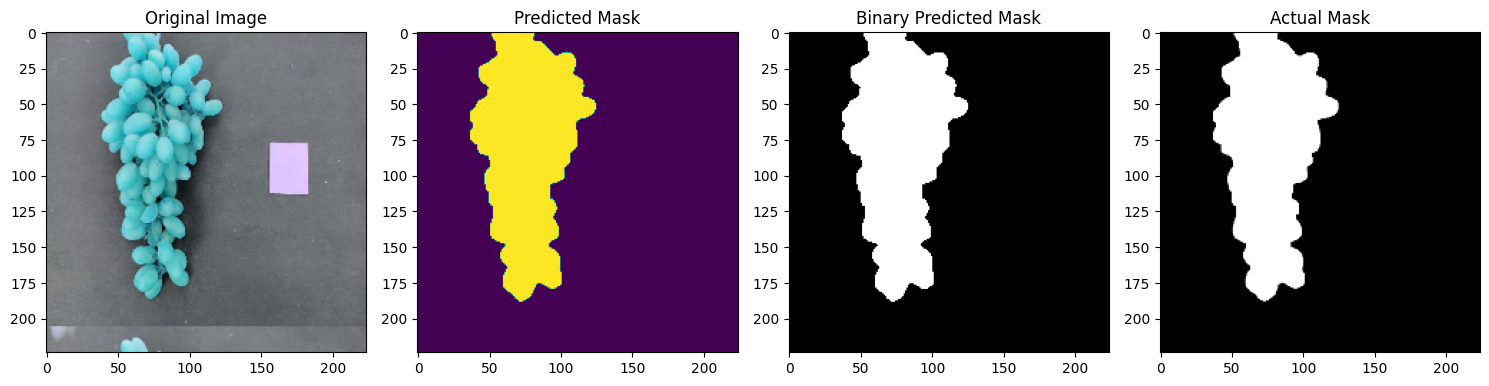

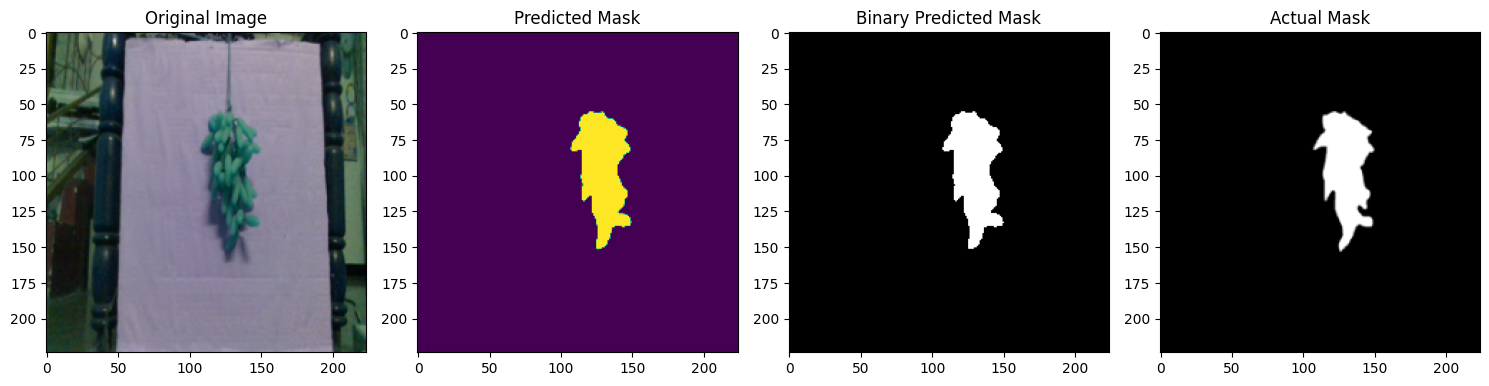

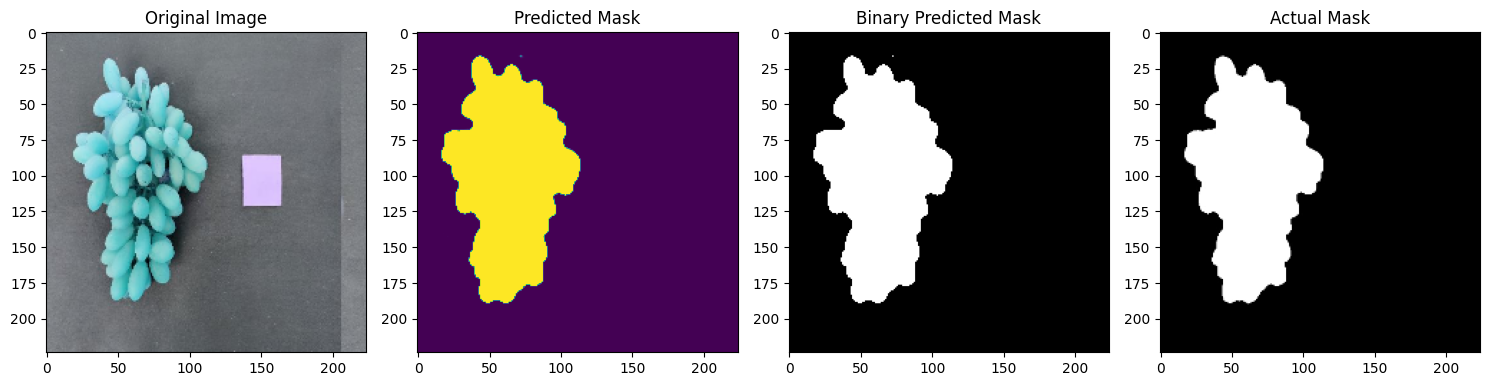

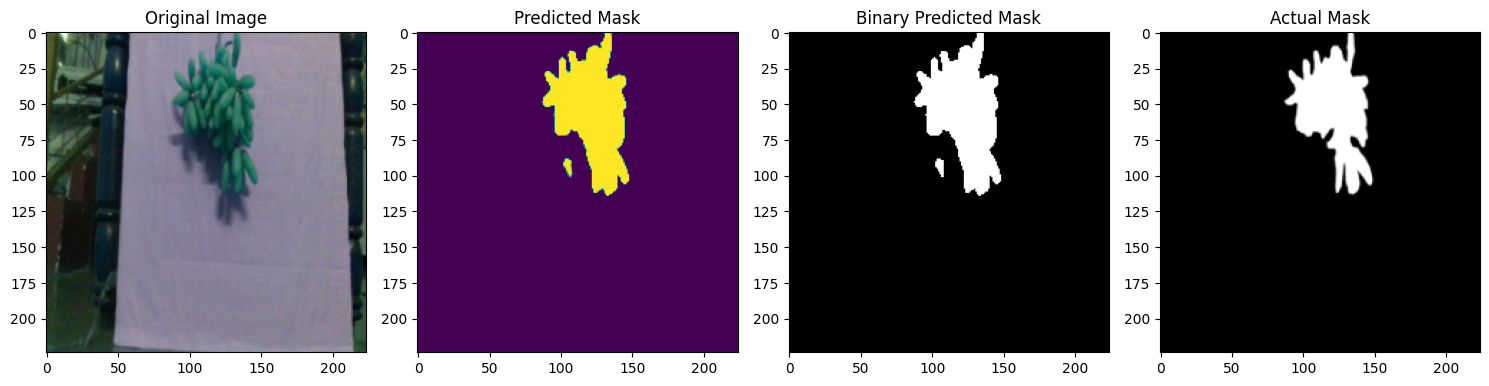

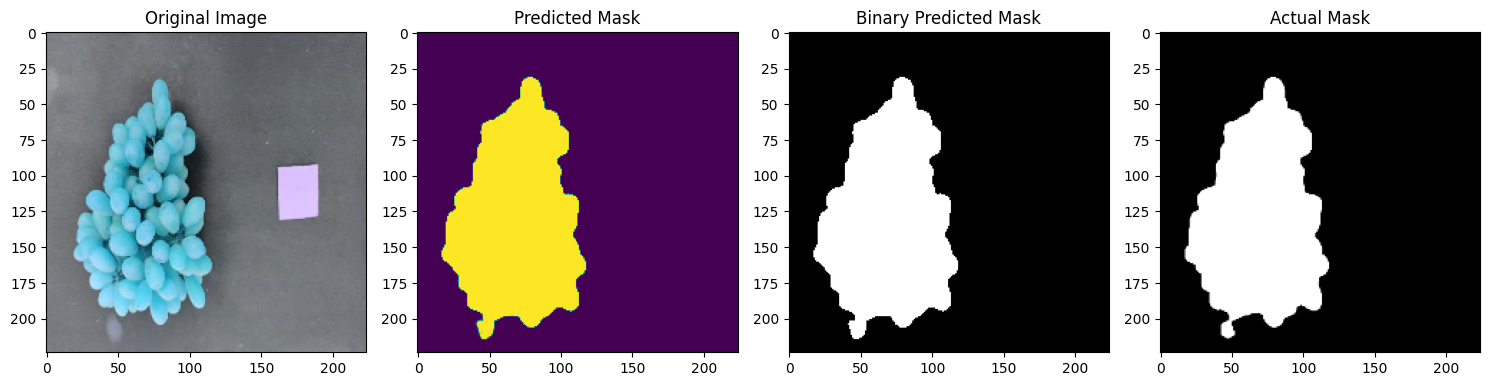

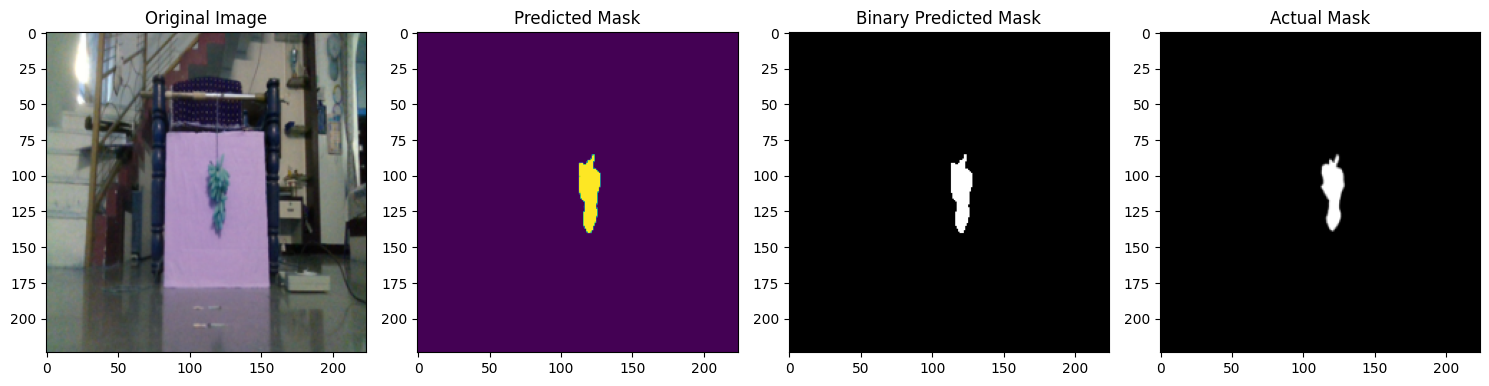

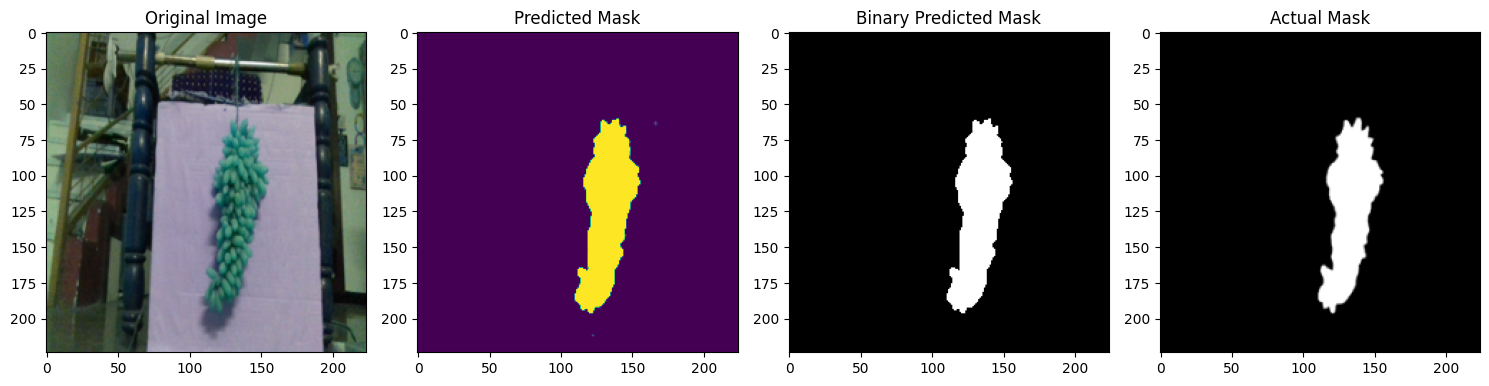

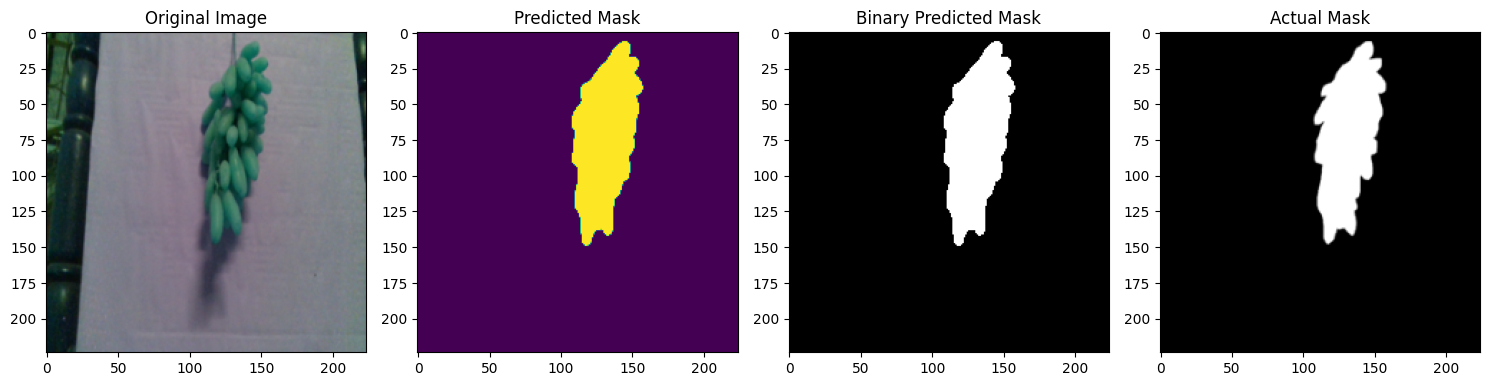

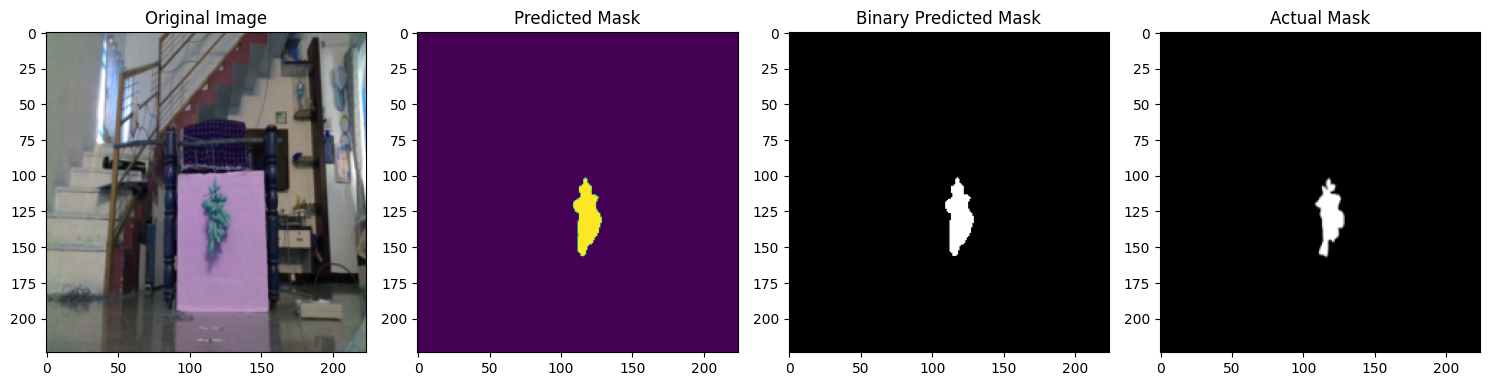

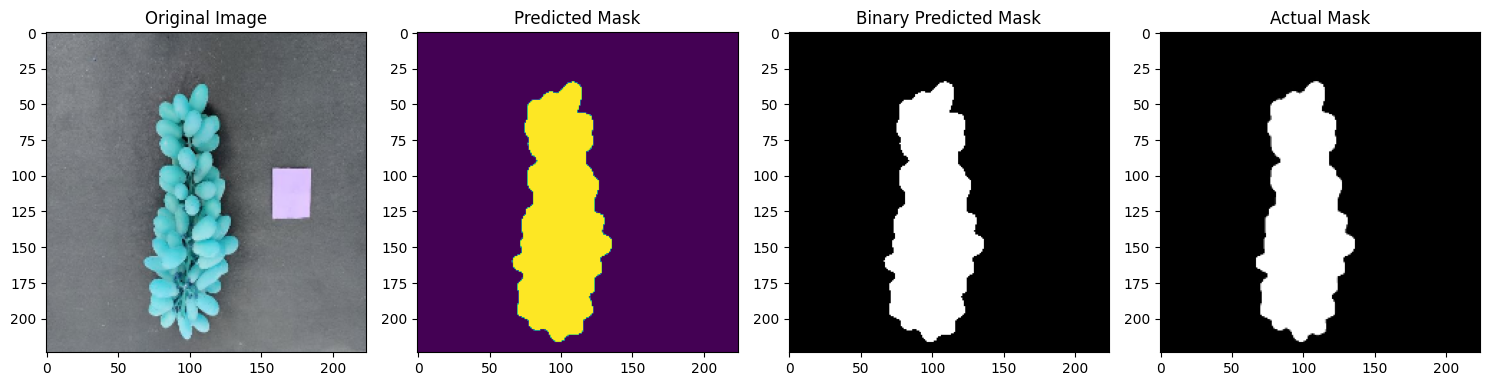

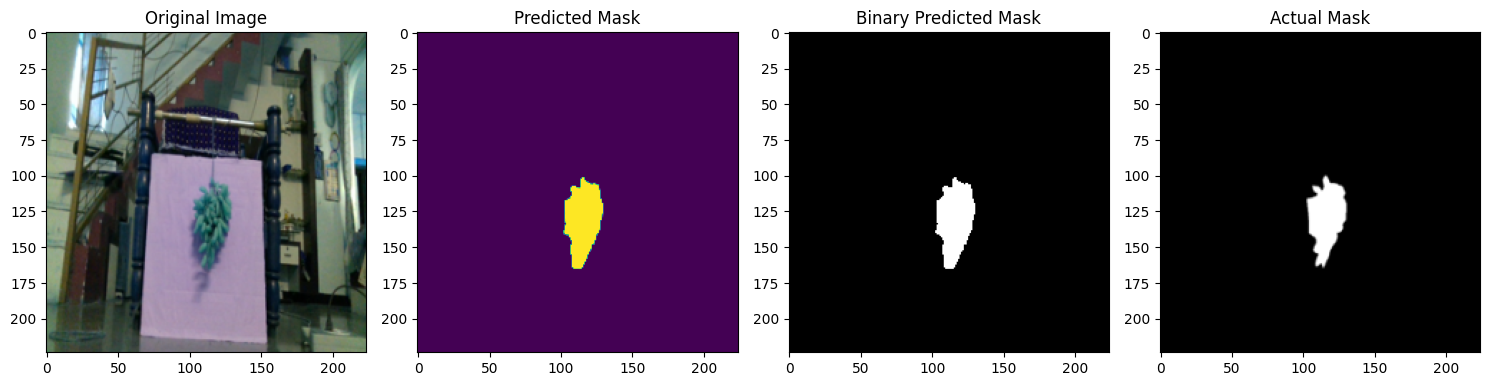

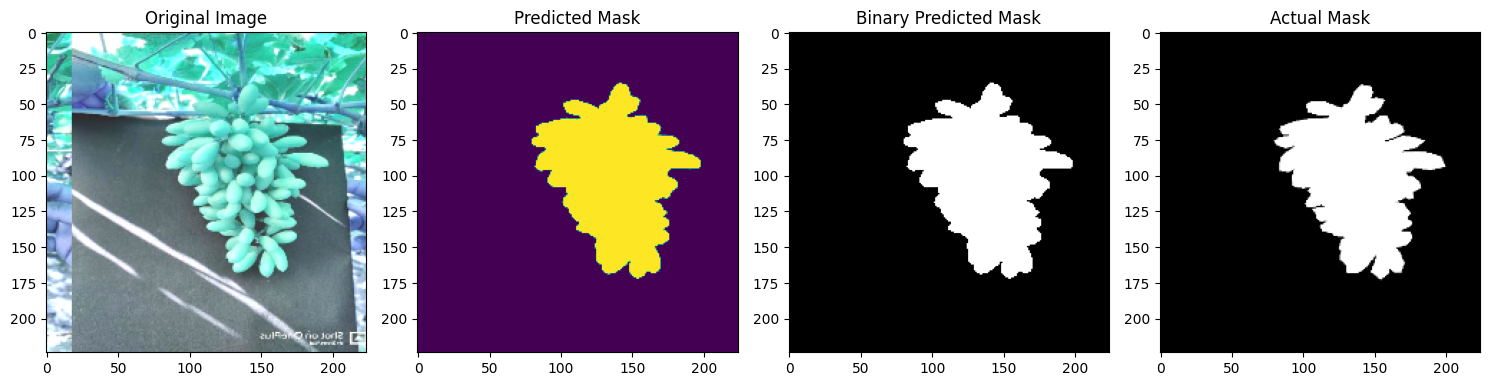

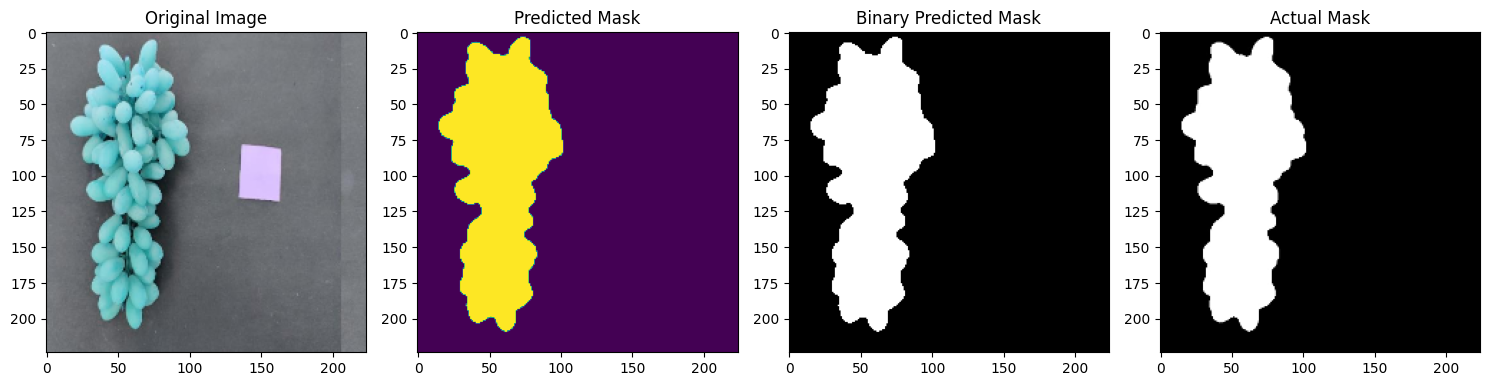

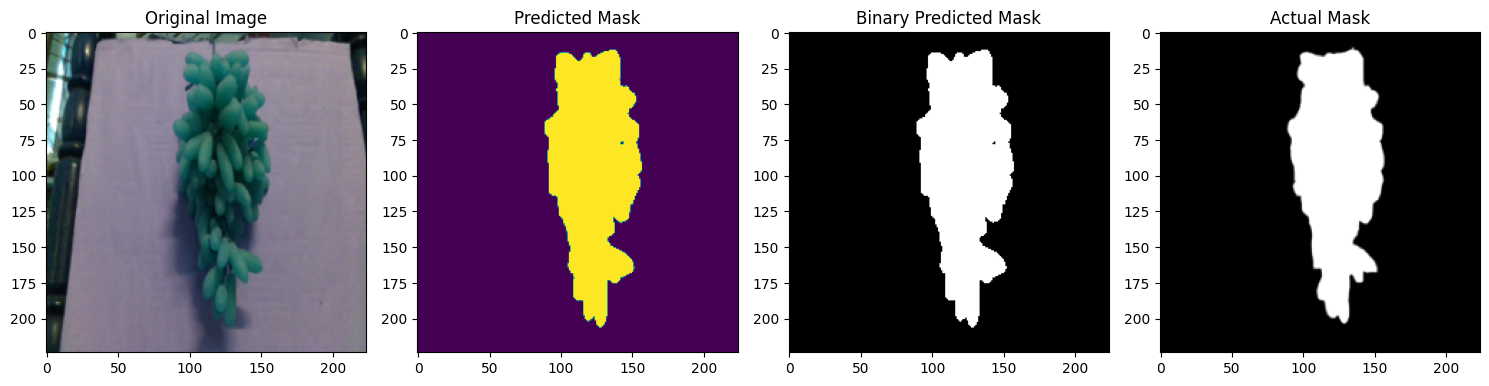

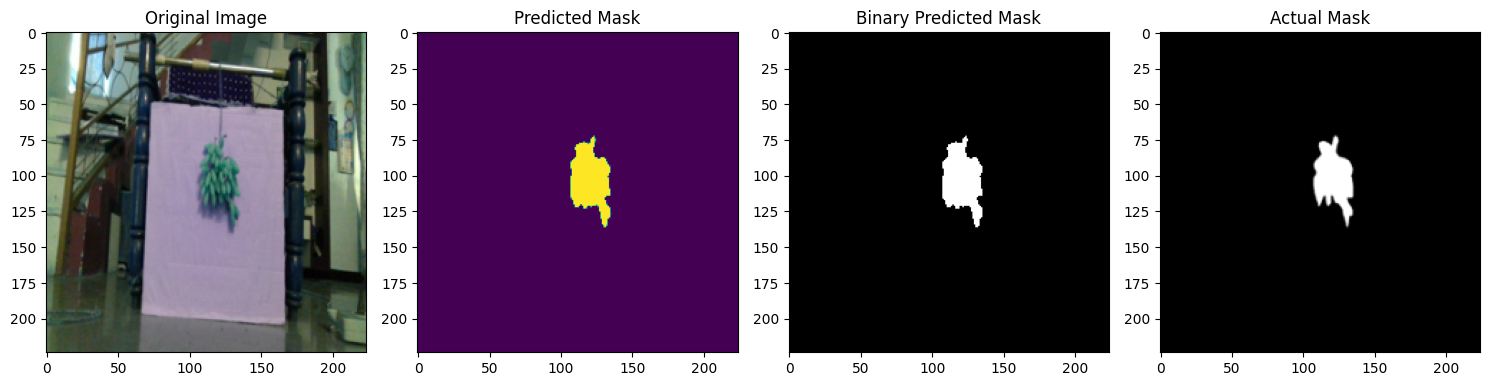

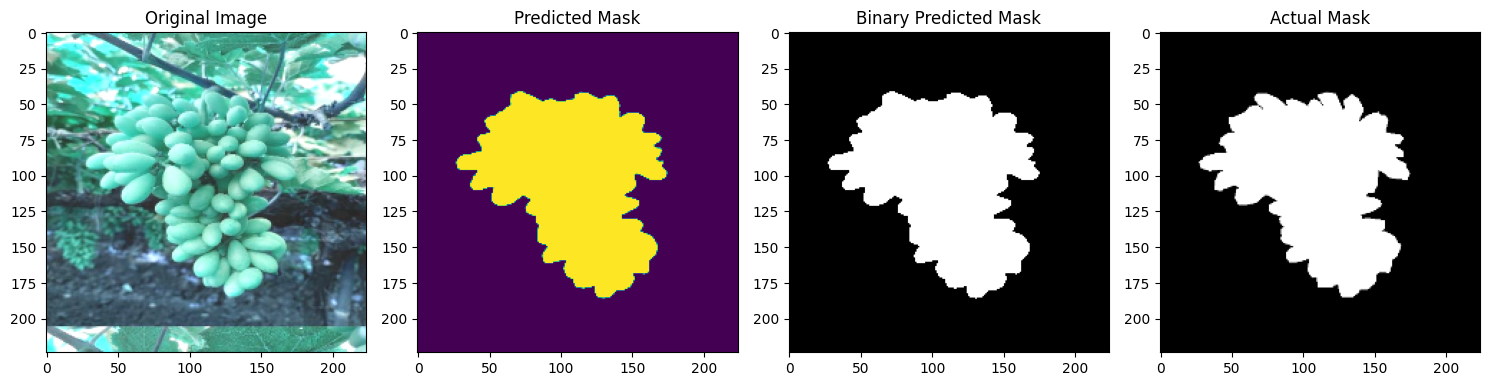

In [76]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()